In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
from glob import glob
import mne
import torch
import pickle

import MARBLE
from MARBLE import postprocessing, plotting

from data_processing import *
from dataset_constructor import RawDataset, BandpowerDataset, EventSegmentDataset


# Set display parameters
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 12

# Find the latest datasets
def find_latest_datasets(datasets_dir='/home/honglab/leijiaxin/MARBLE/datasets'):
    """Find the latest datasets of each type"""
    raw_files = sorted(glob(os.path.join(datasets_dir, '*raw_dataset.npz')))
    bp_files = sorted(glob(os.path.join(datasets_dir, '*bandpower_dataset.npz')))
    event_files = sorted(glob(os.path.join(datasets_dir, '*event_segments_dataset.npz')))
    
    latest_raw = raw_files[-1] if raw_files else None
    latest_bp = bp_files[-1] if bp_files else None
    latest_event = event_files[-1] if event_files else None
    
    return latest_raw, latest_bp, latest_event

# Load the latest datasets
latest_raw, latest_bp, latest_event = find_latest_datasets()
print(f"Latest raw dataset: {os.path.basename(latest_raw) if latest_raw else 'None'}")
print(f"Latest bandpower dataset: {os.path.basename(latest_bp) if latest_bp else 'None'}")
print(f"Latest event segment dataset: {os.path.basename(latest_event) if latest_event else 'None'}")



Latest raw dataset: 20250417_131912_raw_dataset.npz
Latest bandpower dataset: 20250417_131912_bandpower_dataset.npz
Latest event segment dataset: 20250417_131912_event_segments_dataset.npz


In [2]:
bp_dataset = BandpowerDataset.load(latest_bp)
batch_data, batch_time, batch_events = bp_dataset.get_batched_data(
    band_name='gamma',
    start_idx=0,
    num_chunks=500,
    batch_size=50,
    chunks_per_batch_item=10
)

# Prepare data for MARBLE training
pos_list_batched = []
x_list_batched = []
labels_batched = []

# Process each batch separately
for batch_idx in range(len(batch_data)):
    # Get data and events for this batch
    data = batch_data[batch_idx]  # (Time, Channels)
    events = batch_events[batch_idx]  # (Time)
    
    # Create position and vector for this batch
    pos = data[:-1, :]  # (Time-1, Channels)
    x = np.diff(data, axis=0)  # (Time-1, Channels)
    
    # Process labels - trim last time point to match position/vector shapes
    batch_labels = events[:-1]
    
    # Add to lists
    pos_list_batched.append(pos)
    x_list_batched.append(x)
    labels_batched.append(batch_labels)

# Print shapes for debugging
print(f"Created {len(pos_list_batched)} batches of data")
if len(pos_list_batched) > 0:
    print(f"Position shape: {pos_list_batched[0].shape}")
    print(f"Vector shape: {x_list_batched[0].shape}")
    print(f"Labels shape: {labels_batched[0].shape}")

# Use these as anchor, vector, and labels for MARBLE
anchor_list = pos_list_batched
vector_list = x_list_batched
labels = labels_batched



2025-04-18 21:50:31,455 - dataset_constructor - INFO - Loaded bandpower dataset from /home/honglab/leijiaxin/MARBLE/datasets/20250417_131912_bandpower_dataset.npz with 3358 chunks and bands: ['gamma', 'high_gamma']


Created 50 batches of data
Position shape: (38709, 6)
Vector shape: (38709, 6)
Labels shape: (38709,)


In [3]:
# Define flags for loading saved data/model
load_dataset = True 
load_model = True
from MARBLE import utils
# Define save paths
save_path = 'temp_Data/bp_dataset.pkl'
model_path = 'temp_Data/bp_model.pkl'

# Define MARBLE parameters
params = {
    "epochs": 50,  # Use fewer epochs for demonstration
    "order": 2,
    "hidden_channels": [128,64],
    "batch_size": 256,
    "lr": 1e-3,
    "momentum": 0.9, 
    "weight_decay": 1e-4,
    "out_channels": 5,
    "inner_product_features": False,
    "diffusion": True,
    "batch_norm": True,
    "seed": 42,
}

# # Construct or load dataset
k_value = 50
if not load_dataset:
    Marble_Dataset = MARBLE.construct_dataset(
        anchor=anchor_list, 
        vector=vector_list,
        label=labels,  # Use time-based labels
        graph_type="cknn",
        k=k_value,  
        Sampling=False,
        number_of_eigenvectors=100,
    )
    with open(save_path, 'wb') as f:
        pickle.dump(Marble_Dataset, f)
    print(f"Marble_Dataset saved to {save_path}")
else:
    with open(save_path, 'rb') as f:
        Marble_Dataset = pickle.load(f)
    print(f"Marble_Dataset loaded from {save_path}")

# # Train or load model

model = MARBLE.net(Marble_Dataset, params=params)

if not load_model:
    # Clear GPU memory before training
    torch.cuda.empty_cache()
    model.fit(Marble_Dataset)
    # Move model back to CPU before saving
    model = model.cpu()
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {model_path}")
else:
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {model_path}")

transformed_Dataset = model.transform(Marble_Dataset)
# Continue with post-processing (also on CPU)
transformed_Dataset = postprocessing.embed_in_2D(transformed_Dataset)
transformed_Dataset = MARBLE.distribution_distances(transformed_Dataset)

Marble_Dataset loaded from temp_Data/bp_dataset.pkl

---- Settings: 

epochs : 50
order : 2
hidden_channels : [128, 64]
batch_size : 256
lr : 0.001
momentum : 0.9
weight_decay : 0.0001
out_channels : 5
inner_product_features : False
diffusion : True
batch_norm : batch_norm
seed : 42
dropout : 0.0
bias : True
frac_sampled_nb : -1
include_positions : False
include_self : True
vec_norm : False
emb_norm : False
dim_signal : 6
dim_emb : 6
n_sampled_nb : -1

---- Number of features to pass to the MLP:  258
---- Total number of parameters:  42118

Using device cuda:0
Model loaded from temp_Data/bp_model.pkl


/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Performed umap embedding on embedded results.


MemoryError: Unable to allocate 3.62 TiB for an array with shape (998205, 998205) and data type float32

In [53]:
transformed_Dataset = postprocessing.distribution_distances(transformed_Dataset,n_clusters=25)

<Figure size 400x400 with 0 Axes>

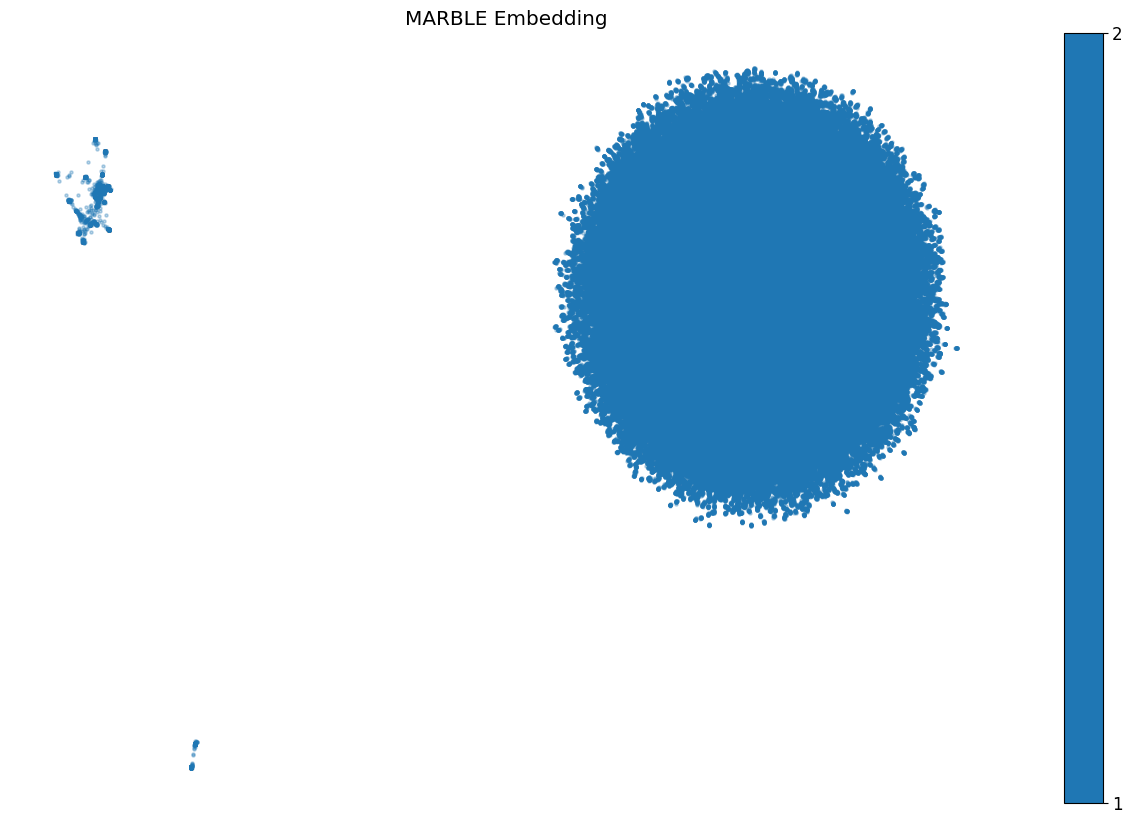

Performed PCA embedding on embedded results.
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
Y

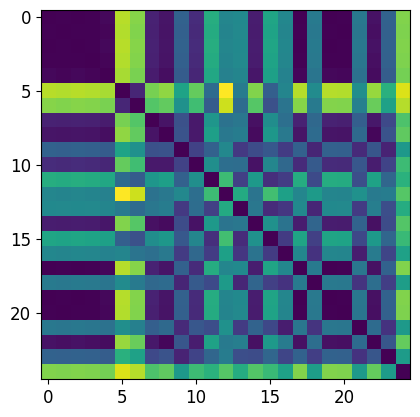

<Figure size 400x400 with 0 Axes>

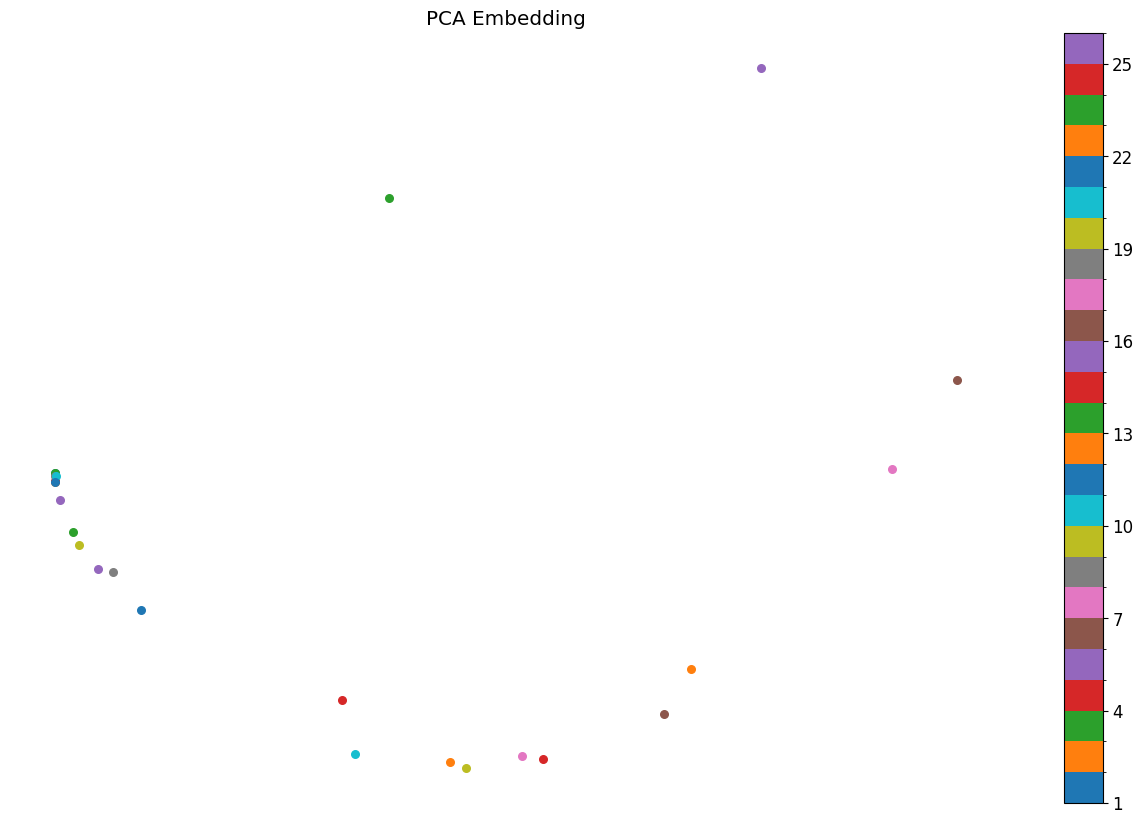

/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Performed umap embedding on embedded results.
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!


<Figure size 400x400 with 0 Axes>

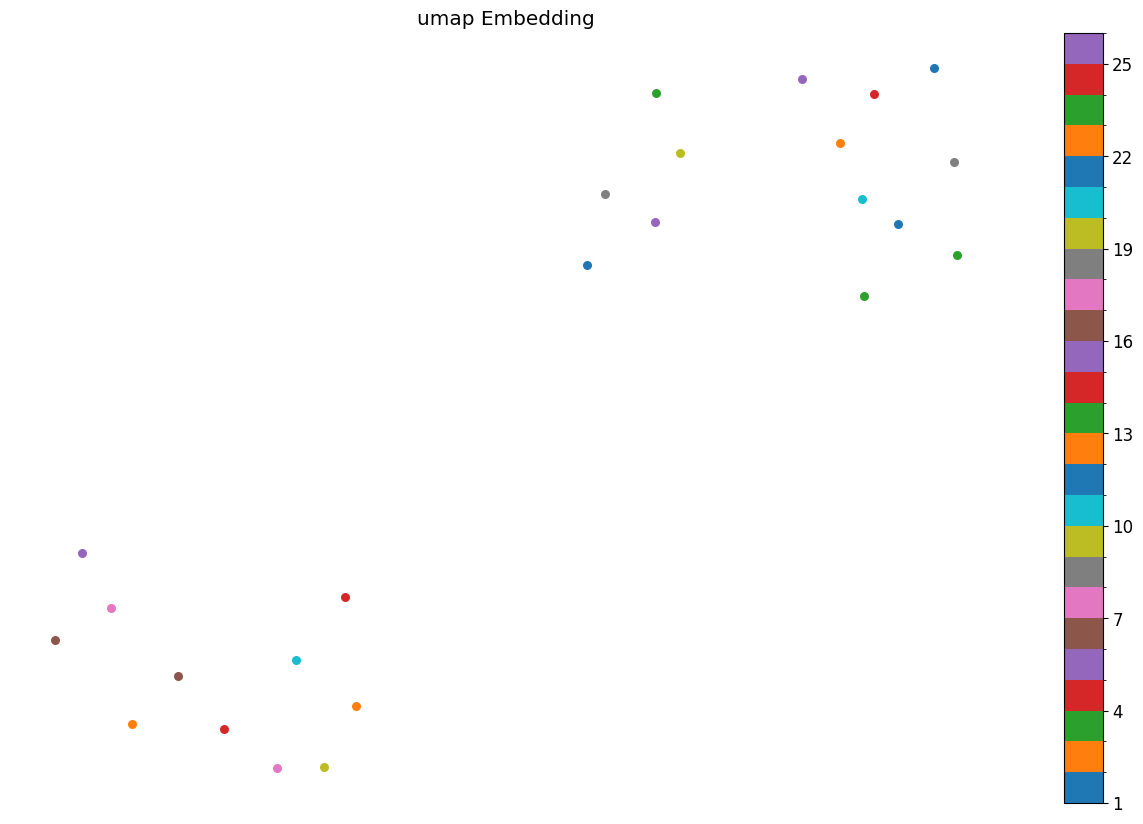

/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:328: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a

Performed Isomap embedding on embedded results.
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories

<Figure size 400x400 with 0 Axes>

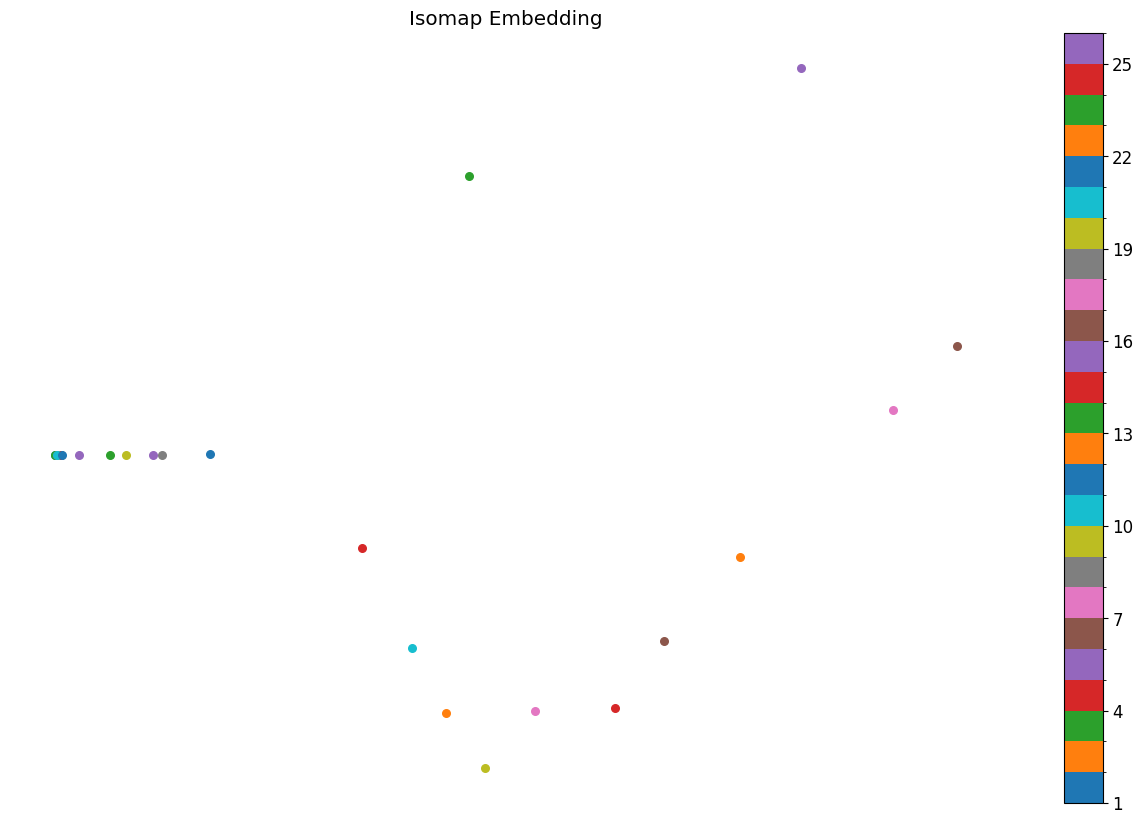

Performed MDS embedding on embedded results.
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
Y

<Figure size 400x400 with 0 Axes>

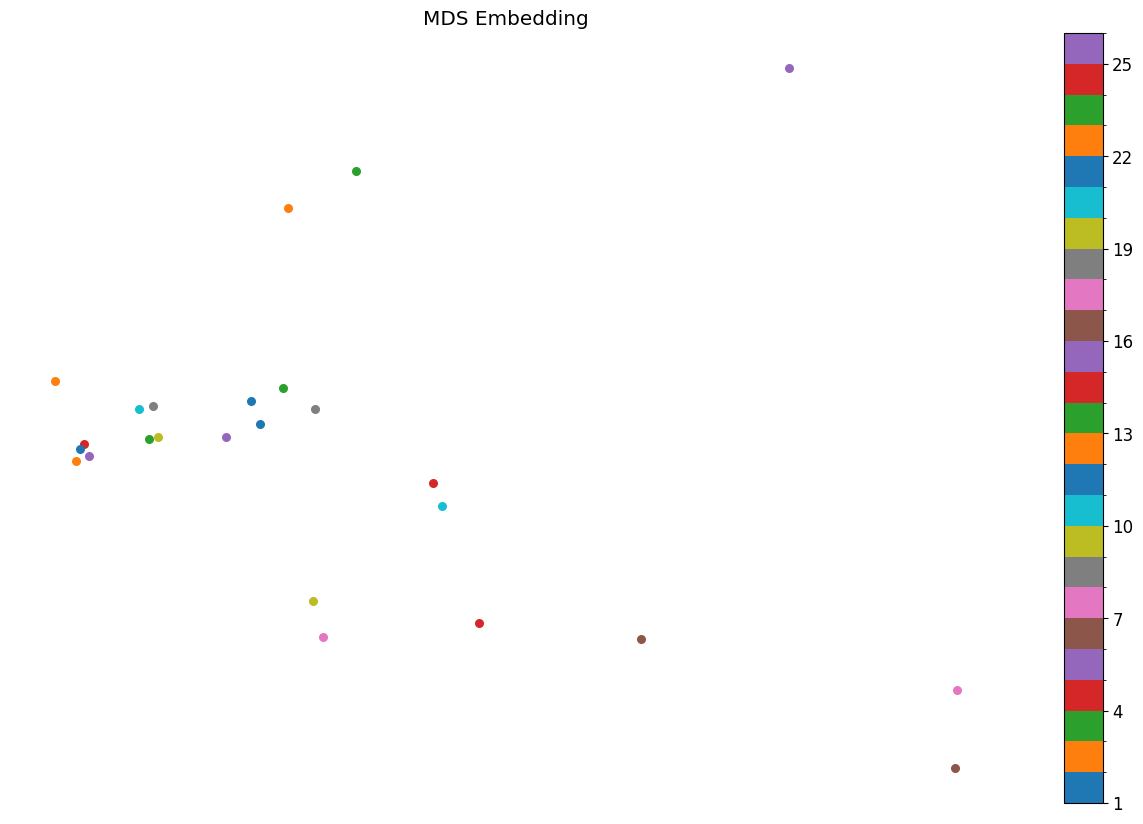

Results saved to temp_Figures/ directory.


In [54]:
from MARBLE import geometry

# Visualize embeddings
plt.figure(figsize=(4, 4))

ax = plotting.embedding(transformed_Dataset, transformed_Dataset.label.numpy().flatten().astype(int))
plt.title('MARBLE Embedding')
plt.savefig('temp_Figures/eeg_marble_embedding.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6.4, 4.8))
im = plt.imshow(transformed_Dataset.dist)

# Plot different embeddings
embed_types = ['PCA',  'umap', 'Isomap', 'MDS']

for embed_typ in embed_types:
    emb, _ = geometry.embed(transformed_Dataset.dist, embed_typ=embed_typ)
    plt.figure(figsize=(4, 4))
    ax = plotting.embedding(emb, np.array(range(0,25)),s=30, alpha=1)
    plt.title(f'{embed_typ} Embedding')
    plt.savefig(f'temp_Figures/eeg_{embed_typ.lower()}_embedding.png', dpi=300, bbox_inches='tight')
    plt.show()

print("=" * 40)
print("Results saved to temp_Figures/ directory.")